In [90]:
import rasterio
import numpy as np
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter, variance
from frost_filter import frost_filter
import cv2 as cv
import sqlite3
import os

%load_ext autoreload
%autoreload 2
mpl.rcParams['figure.dpi'] = 150

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0


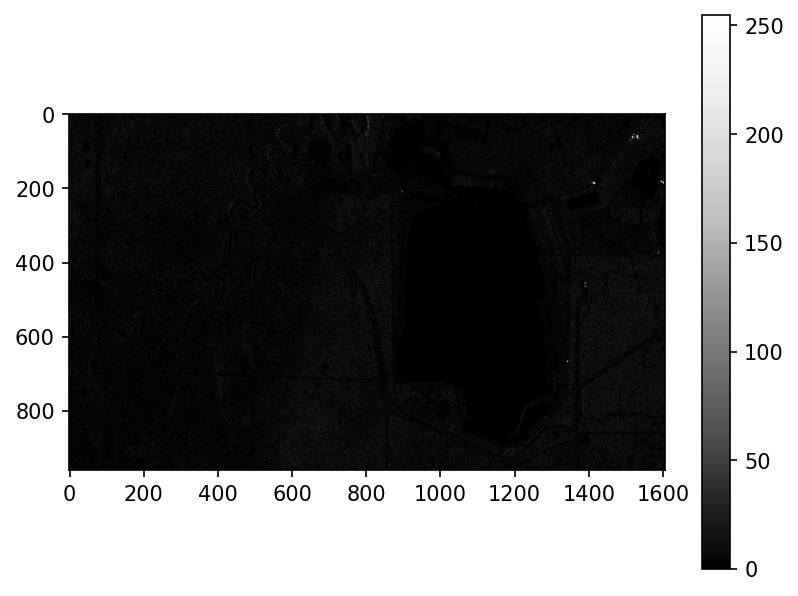

In [65]:
base_path = Path("/home/ebiederstadt/Documents/sentinel_cache/bbox-111.9392593_56.936104843_-111.6770842_57.023933326/2019-09-13")

vh = rasterio.open(base_path.joinpath("VH.tif")).read(1)
vv = rasterio.open(base_path.joinpath("VV.tif")).read(1)

plt.imshow(vh, cmap="Greys_r")
plt.colorbar()

print(vh.min())

In [78]:
# https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python
def lee_filter(data, size):
    img_mean = uniform_filter(data, (size, size)) # L_m
    img_sqr_mean = uniform_filter(data ** 2, (size, size)) 
    img_variance = img_sqr_mean - img_mean ** 2 # L_v

    overall_variance = variance(data) # AV
    img_weights = img_variance / (img_variance + overall_variance) # K 
    img_output = img_mean + img_weights * (data - img_mean)

    return img_output

vh_filtered = lee_filter(vh, size=7)
vh_filtered = 10 * np.log10(vh_filtered, out=np.zeros_like(vh_filtered), where=(vh_filtered != 0))
vh_filtered[vh_filtered < 0] = 0.0

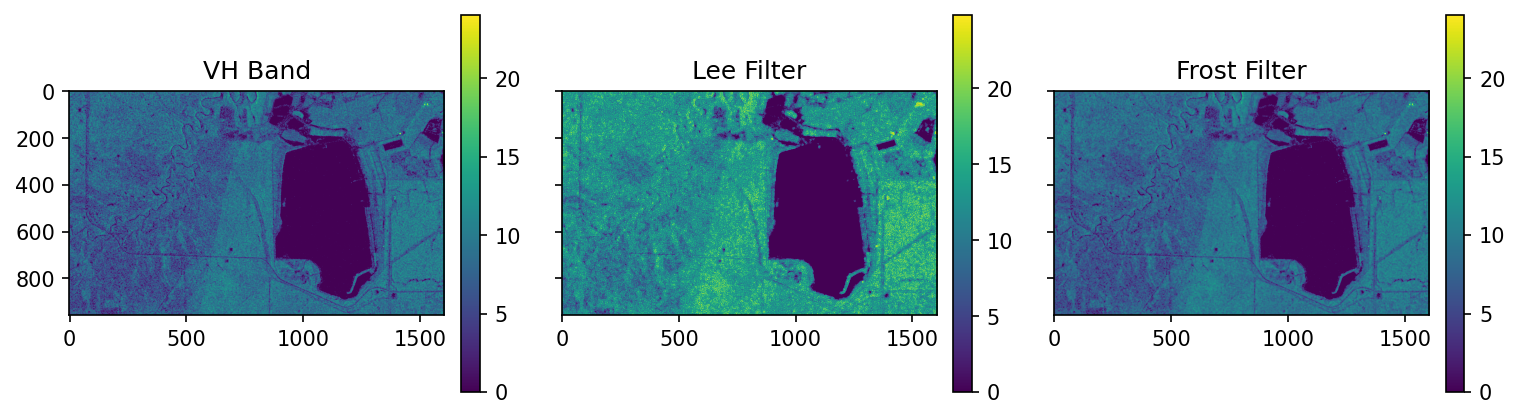

In [86]:
vh_filtered = vh.astype(np.float64)
vh_filtered = 10 * np.log10(vh_filtered, out=np.zeros_like(vh_filtered), where=(vh_filtered != 0))
vh_filtered[vh_filtered < 0] = 0.0

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12, 10))
im = ax[0].imshow(vh_filtered)
ax[0].set_title("VH Band")
plt.colorbar(im, fraction=0.046, pad=0.04)

vh_filtered = lee_filter(vh, size=7)
vh_filtered = 10 * np.log10(vh_filtered, out=np.zeros_like(vh_filtered), where=(vh_filtered != 0))
vh_filtered[vh_filtered < 0] = 0.0

im = ax[1].imshow(vh_filtered)
ax[1].set_title("Lee Filter")
plt.colorbar(im,fraction=0.046, pad=0.04)

vh_frost = frost_filter(vh.astype(np.float64), damping_factor=3, win_size=7)
vh_frost = 10 * np.log10(vh_frost, out=np.zeros_like(vh_frost), where=(vh_frost != 0))
vh_frost[vh_frost < 0] = 0.0

im = ax[2].imshow(vh_frost)
ax[2].set_title("Frost Filter")
plt.colorbar(im,fraction=0.046, pad=0.04)

In [97]:
con = sqlite3.connect(base_path.parent.joinpath("approximation.db"))
cur = con.cursor()

sql = "INSERT INTO sentinel1(year, month, day) VALUES(?, ?, ?)"
data = []

for root, dirs, files in os.walk(base_path.parent):
    for dir in dirs:
        if base_path.parent.joinpath(dir).joinpath("VV.tif").exists():
            year, month, day = [int(x) for x in dir.split("-")]
            data.append((year, month, day))

cur.executemany(sql, data)
con.commit()

In [104]:
# For each directory that does not have filtered data, add it!

def to_db(filtered):
    filtered = 10 * np.log10(filtered, out=np.zeros_like(filtered), where=(filtered != 0))
    filtered[filtered < 0] = 0.0
    return filtered

res = cur.execute("SELECT year, month, day FROM sentinel1 WHERE filtered is NULL")
dates = res.fetchall()

sql = "INSERT INTO sentinel1(filtered) VALUES(?)"
data = []
for date in dates:
    year, month, day = date
    path = base_path.parent.joinpath(f"{year}-{month:02}-{day:02}")

    tiff = rasterio.open(path.joinpath("VV.tif"))
    vv = tiff.read(1).astype(np.float64)
    vh = rasterio.open(path.joinpath("VH.tif")).read(1).astype(np.float64)

    vv_filtered = frost_filter(vv, damping_factor=3, win_size=7)
    vv_filtered = to_db(vv_filtered)

    vh_filtered = frost_filter(vh, damping_factor=3, win_size=7)
    vh_filtered = to_db(vh_filtered)

    with rasterio.open(
        path.joinpath("VV_filtered.tif"),
        "w",
        driver="GTiff",
        height=vv.shape[0],
        width=vv.shape[1],
        count=1,
        dtype=np.float64,
        crs=tiff.crs,
        transform=tiff.transform
     ) as out:
        out.write(vv_filtered, 1)
    
    with rasterio.open(
        path.joinpath("VH_filtered.tif"),
        "w",
        driver="GTiff",
        height=vv.shape[0],
        width=vv.shape[1],
        count=1,
        dtype=np.float64,
        crs=tiff.crs,
        transform=tiff.transform
    ) as out:
        out.write(vh_filtered, 1)

    tiff.close()

    data.append((1))
    print(f"Computed for {path}")

cur.executemany(sql, data)
con.commit()

Computed for /home/ebiederstadt/Documents/sentinel_cache/bbox-111.9392593_56.936104843_-111.6770842_57.023933326/2019-05-17
Computed for /home/ebiederstadt/Documents/sentinel_cache/bbox-111.9392593_56.936104843_-111.6770842_57.023933326/2019-09-08
Computed for /home/ebiederstadt/Documents/sentinel_cache/bbox-111.9392593_56.936104843_-111.6770842_57.023933326/2019-06-22
Computed for /home/ebiederstadt/Documents/sentinel_cache/bbox-111.9392593_56.936104843_-111.6770842_57.023933326/2019-12-06
Computed for /home/ebiederstadt/Documents/sentinel_cache/bbox-111.9392593_56.936104843_-111.6770842_57.023933326/2019-06-04
Computed for /home/ebiederstadt/Documents/sentinel_cache/bbox-111.9392593_56.936104843_-111.6770842_57.023933326/2019-09-01
Computed for /home/ebiederstadt/Documents/sentinel_cache/bbox-111.9392593_56.936104843_-111.6770842_57.023933326/2019-12-01
Computed for /home/ebiederstadt/Documents/sentinel_cache/bbox-111.9392593_56.936104843_-111.6770842_57.023933326/2019-09-14
Computed

ProgrammingError: parameters are of unsupported type